In [331]:
import numpy as np
import pickle
import seaborn as sns
import sys
import folium
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from typing import List, Tuple
from branca.element import Figure
from collections import defaultdict
sys.path.append("..")

from src.utils import get_dvc_dir
from src.ETL.constants import CROP_PROB, SUBSET, FEATURE_PATH, START
from src.models.data import CropDataset
from src.datasets_labeled import labeled_datasets
from src.band_calculations import _calculate_ndvi, BANDS

In [276]:
def get_labelled_array(save_path):
    with open(save_path, "rb") as f:
        return pickle.load(f).labelled_array

In [195]:
df = pd.concat([d.load_labels() for d in labeled_datasets])

In [366]:
df = df[(df[SUBSET] != "testing") & (df["country"].isin(["Kenya", "Togo", "Ethiopia"]))]
df["is_crop"] = df[CROP_PROB] > 0.5
df["labelled_array"] = np.vectorize(get_labelled_array, otypes=[np.ndarray])(df[FEATURE_PATH])

In [380]:
df["labelled_array_flattened"] = np.vectorize(np.matrix.flatten, otypes=[np.ndarray])(df["labelled_array"])

In [521]:
df["NDVI_series"] = df["labelled_array"].apply(lambda x: x[:, -1])
df["mean_bands"] = df["labelled_array"].apply(lambda x: x.mean(axis=0))
df["std_bands"] = df["labelled_array"].apply(lambda x: x.std(axis=0))

In [522]:
df["NDVI_series_and_mean_bands"] = df.apply(lambda row: np.concatenate(
    [row["NDVI_series"], row["mean_bands"]]), axis=1)

df["mean_and_std_bands"] = df.apply(lambda row: np.concatenate(
    [row["mean_bands"], row["std_bands"]]), axis=1)

In [281]:
months = ["Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec", "Jan", "Feb", "Mar"]

In [282]:
df_long_data = []
for i, row in tqdm(df.iterrows(), total=len(df)):
    row_dict = row.to_dict()
    for month, ndvi in zip(months, row_dict["NDVI_series"]):
        new_row = row_dict.copy()
        new_row["month"] = month
        new_row["ndvi"] = ndvi
        df_long_data.append(new_row)
df_long = pd.DataFrame(df_long_data)

  0%|          | 0/14810 [00:00<?, ?it/s]

In [564]:
df_long_data2 = []
for i, row in tqdm(df.iterrows(), total=len(df)):
    row_dict = row.to_dict()
    for name, value in zip(BANDS + ["NDVI"], row_dict["mean_bands"]):
        new_row = row_dict.copy()
        new_row["band_name"] = name
        new_row["band_value"] = value
        df_long_data2.append(new_row)
df_long2 = pd.DataFrame(df_long_data2)

  0%|          | 0/14810 [00:00<?, ?it/s]

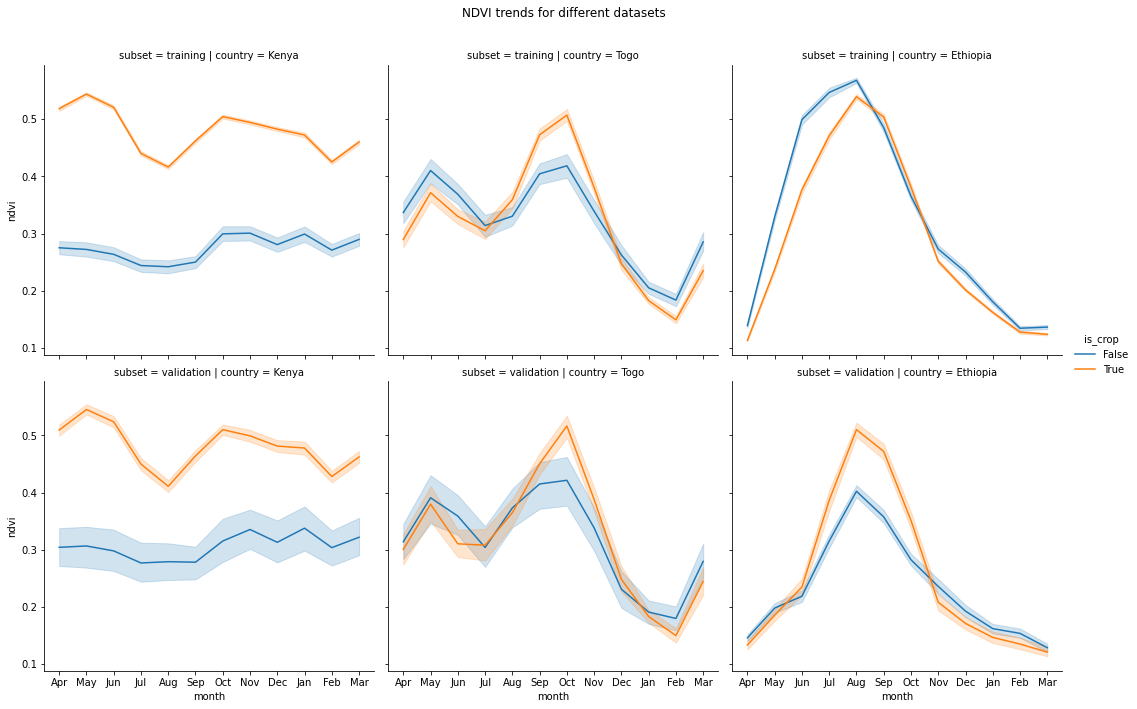

In [283]:
g = sns.FacetGrid(df_long, col="country", row=SUBSET, hue="is_crop", height=5)
g.map(sns.lineplot, "month", "ndvi")
g.add_legend()
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("NDVI trends for different datasets");

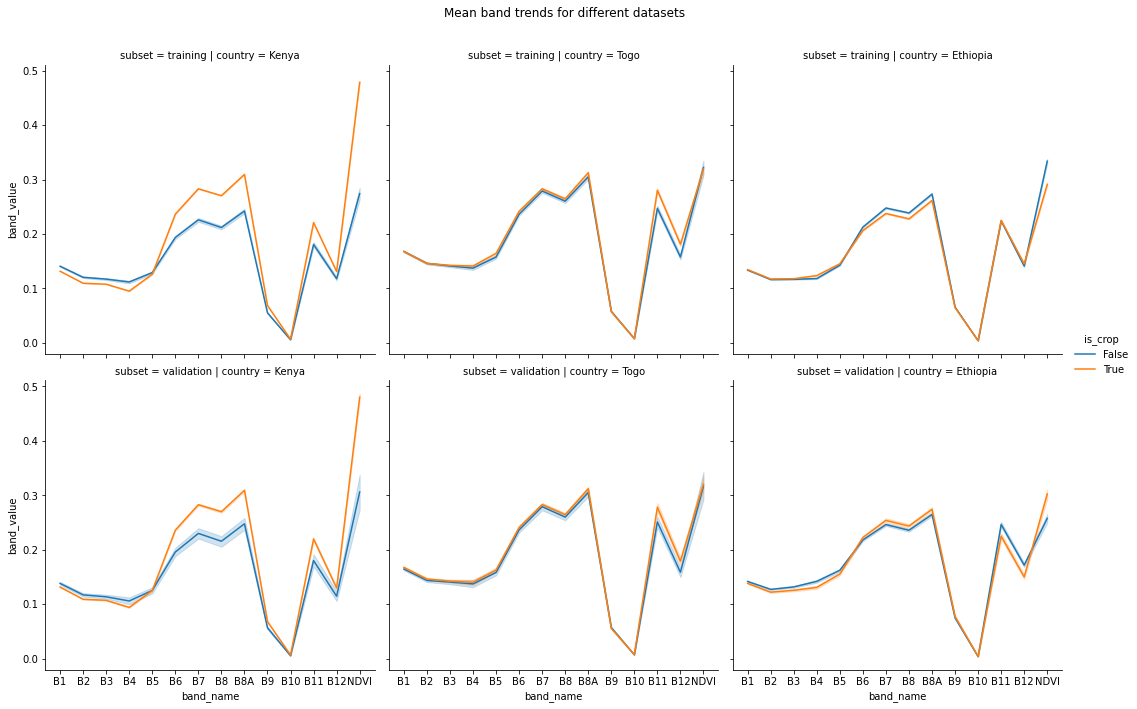

In [569]:
g = sns.FacetGrid(df_long2, col="country", row=SUBSET, hue="is_crop", height=5)
g.map(sns.lineplot, "band_name", "band_value")
g.add_legend()
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Mean band trends for different datasets");

In [397]:
def run_baseline(df_train, df_val, clf=SVC(), X_col="NDVI_series", input_months=None):
    is_train = df_train[SUBSET] == "training"    
    X_train = df_train[is_train][X_col].to_list()
    if input_months:
        X_train = [x[:input_months] for x in X_train]
    y_train = df_train[is_train]["is_crop"]
    assert len(X_train) == len(y_train)
    
    is_val = df_val[SUBSET] == "validation"
    X_val = df_val[is_val][X_col].to_list()
    if input_months:
        X_val = [x[:input_months] for x in X_val]
    y_val = df_val[is_val]["is_crop"]
    assert len(X_val) == len(y_val)
    
    print(f"Training: {len(X_train)}")
    print(f"Validation: {len(X_val)}")
    
    clf.fit(X_train, y_train)
    y_val_pred = clf.predict(X_val)
    y_train_pred = clf.predict(X_train)
    print(f"Train f1: {f1_score(y_train, y_train_pred)}")
    print(f"Val f1: {f1_score(y_val, y_val_pred)}")      

# Baselines - Kenya
- RandomForestClassifier on all data is best
- RandomForestClassifier on just mean bands is close (-2%)
- RandomForestClassifier overfits on training set but results in higher validation score than SVC which does not overfit

In [401]:
run_baseline(
    df_train=df[df["dataset"] == "Kenya"],
    df_val=df[df["dataset"] == "Kenya"],
    clf=SVC(),
    X_col="labelled_array_flattened"
)

Training: 6914
Validation: 861
Train f1: 0.9468085106382979
Val f1: 0.9403107113654947


In [470]:
run_baseline(
    df_train=df[df["dataset"] == "Kenya"],
    df_val=df[df["dataset"] == "Kenya"],
    clf=RandomForestClassifier(random_state=1),
    X_col="labelled_array_flattened"
)

Training: 6914
Validation: 861
Train f1: 1.0
Val f1: 0.9611890999174236


In [477]:
# Just using the NDVI time series gets a high f1-score
run_baseline(
    df_train=df[df["dataset"] == "Kenya"],
    df_val=df[df["dataset"] == "Kenya"],
    clf=RandomForestClassifier(random_state=1), 
    X_col="NDVI_series"
)

Training: 6914
Validation: 861
Train f1: 1.0
Val f1: 0.9136400322841001


In [478]:
# Just using the mean band values over the year get a high f1-score
run_baseline(
    df_train=df[df["dataset"] == "Kenya"],
    df_val=df[df["dataset"] == "Kenya"],
    clf=RandomForestClassifier(random_state=1),
    X_col="mean_bands"
)

Training: 6914
Validation: 861
Train f1: 1.0
Val f1: 0.9418509418509419


In [480]:
# For Kenya, band comparison does most of the work, adding NDVI time series does not improve f1 score much
run_baseline(
    df_train=df[df["dataset"] == "Kenya"],
    df_val=df[df["dataset"] == "Kenya"],
    clf=RandomForestClassifier(random_state=1),
    X_col="NDVI_series_and_mean_bands"
)

Training: 6914
Validation: 861
Train f1: 1.0
Val f1: 0.945126945126945


# Baselines - Togo
- RandomForestClassifier on all data is best
- RandomForestClassifier on NDVI series only is -3% 
- Unlike Kenya mean_bands do help the classifier more than the NDVI series

In [481]:
run_baseline(
    df_train=df[df["dataset"] == "Togo"],
    df_val=df[df["dataset"] == "Togo"],
    clf=RandomForestClassifier(random_state=1),
    X_col="labelled_array_flattened"
)

Training: 999
Validation: 277
Train f1: 1.0
Val f1: 0.8700906344410876


In [482]:
run_baseline(
    df_train=df[df["dataset"] == "Togo"],
    df_val=df[df["dataset"] == "Togo"],
    clf=RandomForestClassifier(random_state=1),
    X_col="NDVI_series"
)

Training: 999
Validation: 277
Train f1: 1.0
Val f1: 0.8473520249221183


In [488]:
run_baseline(
    df_train=df[df["dataset"] == "Togo"],
    df_val=df[df["dataset"] == "Togo"],
    clf=RandomForestClassifier(random_state=1),
    X_col="mean_bands"
)

Training: 999
Validation: 277
Train f1: 1.0
Val f1: 0.8025078369905956


# Ethiopia Tigray 2020
- SVC does slightly better than RandomForest on all data
- Best results are overfitting a RandomForestClassifier on mean and std bands

In [533]:
run_baseline(
    df_train=df[(df["dataset"] == "Ethiopia") & (pd.to_datetime(df[START]).dt.year <= 2020)],
    df_val=df[df["dataset"] == "Ethiopia_Tigray_2020"],
    clf=SVC(),
    X_col="labelled_array_flattened"
)

Training: 4208
Validation: 520
Train f1: 0.9083538949594642
Val f1: 0.528


In [529]:
run_baseline(
    df_train=df[(df["dataset"] == "Ethiopia") & (pd.to_datetime(df[START]).dt.year <= 2020)],
    df_val=df[df["dataset"] == "Ethiopia_Tigray_2020"],
    clf=RandomForestClassifier(random_state=1),
    X_col="mean_and_std_bands"
)

Training: 4208
Validation: 520
Train f1: 1.0
Val f1: 0.5570291777188329


# Ethiopia Tigray 2021
- SVC performs better because it generalizes better and train and validation are real different?
- NDVI series and std_bands perform +8% better, might be a fluke

In [548]:
run_baseline(
    df_train=df[(df["dataset"] == "Ethiopia") & (pd.to_datetime(df[START]).dt.year <= 2020)],
    df_val=df[df["dataset"] == "Ethiopia_Tigray_2021"],
    clf=SVC(),
    input_months=6,
    X_col="labelled_array_flattened"
)

Training: 4208
Validation: 726
Train f1: 0.80378810298905
Val f1: 0.5211097708082026


In [550]:
run_baseline(
    df_train=df[(df["dataset"] == "Ethiopia") & (pd.to_datetime(df[START]).dt.year <= 2020)],
    df_val=df[df["dataset"] == "Ethiopia_Tigray_2021"],
    clf=SVC(),
    input_months=6,
    X_col="NDVI_series"
)

Training: 4208
Validation: 726
Train f1: 0.8554973821989529
Val f1: 0.6005025125628141


In [561]:
run_baseline(
    df_train=df[(df["dataset"] == "Ethiopia") & (pd.to_datetime(df[START]).dt.year <= 2020)],
    df_val=df[df["dataset"] == "Ethiopia_Tigray_2021"],
    clf=SVC(),
    X_col="std_bands"
)

Training: 4208
Validation: 726
Train f1: 0.7961416642672042
Val f1: 0.6059850374064838
